# Ejemplo de [aquí](https://keras.io/examples/timeseries/timeseries_anomaly_detection/#build-a-model)

En este caso es necesario disponer de un conjunto de datos que no contenga ninguna anomalía. <br>
Con el autoencoder se aprende cual es "la forma que debería tener" y la aplica al test.

In [1]:
"""
    1. Carga de librerías
    2. Variables de configuración
"""

import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md
from numpy.random import seed

seed(42)
SPLIT_THRESHOLD = 10  # % del total que será train. 10 para no tener outliers
TIME_STEPS = 32  # Temporalidad. DEBE SER PAR

timestamp  value
1585  2015-03-04 09:47:53     30
1586  2015-03-04 09:52:53     20
1587  2015-03-04 09:57:53     31
1588  2015-03-04 10:02:53     27
1589  2015-03-04 10:07:53     25

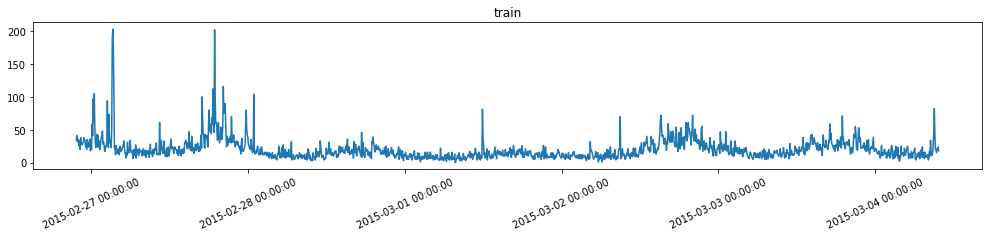

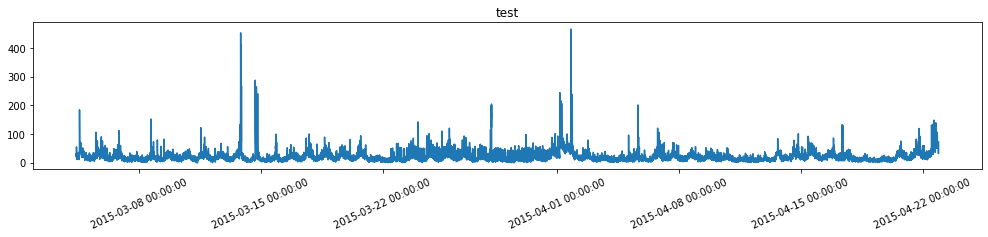

In [2]:
"""
    1. Carga de datos
    2. Visualización de datos
    
    El código está hecho para datos con forma:
        timestamp: string '%Y-%m-%d %H:%M:%S'
        value: numeric
    Asegurate que tus datos tengan mismo formato.
        
    Se usa el dataset Numenta Anomaly Benchmark(NAB) que 
    contiene múltiples datasets populares de series 
    temporales con anomalías.
"""

master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"
df_twitter_volume_GOOG_suffix = "realTweets/Twitter_volume_GOOG.csv"
df_twitter_volume_GOOG_url = master_url_root + df_twitter_volume_GOOG_suffix
df_twitter_volume_GOOG = pd.read_csv(df_twitter_volume_GOOG_url)
split_sample = int(np.ceil(df_twitter_volume_GOOG.shape[0]*SPLIT_THRESHOLD/100))
df_train = df_twitter_volume_GOOG.iloc[:split_sample]
df_test = df_twitter_volume_GOOG.iloc[split_sample:]
display(df_test.head()) 


def plot_dates_values(data, title):
    dates = data["timestamp"].to_list()
    values = data["value"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    plt.figure(figsize=(17,3))
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca() 
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)
    plt.title(title)
    plt.plot(dates, values)
    plt.show()
    
plot_dates_values(df_train, "train")
plot_dates_values(df_test, "test")

In [3]:
"""
    Normalizar los valores para alimentar la CNN
"""

def get_value_from_df(df):
    return df.value.to_list()


def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std

# Pasar la columna a vector python
training_value = get_value_from_df(df_train)

# Normalizar valores y guardar media y desviación estandar para normalizar el test 
training_value, training_mean, training_std = normalize(training_value)

# # Otra forma de hacerlo. Predeterminada normalización L2, especificar en otro caso.
# from sklearn.preprocessing import normalize
# normalized_tuple = normalize(df_small_noise.iloc[:,1].tolist())
# training_value = normalized_tuple[0]
# training_mean = normalized_tuple[1]
# training_std = normalized_tuple[2]
    
print(len(training_value))

1585


In [4]:
"""
    Darle forma a los datos para alimentar la CNN
    
    Datos originales : 1, 2, 3, 4, 5, 6, 7, 8, 9
    Datos transform:   0, 1, 2
                       1, 2, 3
                       2, 3, 4
                       3, 4, 5
                       4, 5, 6
                       5, 6, 7
                       6, 7, 8
                       7, 8, 9
"""

# Crea una matriz siendo cada fila una ventana deslizante de len=TIME_STEPS
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    # Convertir de 2D a 3D para poder alimentar la CNN
    return np.expand_dims(output, axis=2)


x_train = create_sequences(training_value)
print("Training input shape: ", x_train.shape)


Training input shape:  (1553, 32, 1)


In [5]:
"""
    Crear el modelo CNN.
    OJO! necesario TF >= 2.3.X
    https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11
"""

model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        
        layers.Conv1D(filters=32, 
                      kernel_size=5, 
                      padding="same", 
                      strides=2, 
                      activation="relu"),
        
        layers.Dropout(rate=0.2),
        
        layers.Conv1D(filters=16, 
                      kernel_size=7, 
                      padding="same", 
                      strides=2, 
                      activation="relu"),
        
        layers.Conv1DTranspose(filters=16, 
                               kernel_size=7, 
                               padding="same", 
                               strides=2, 
                               activation="relu"),
        
        layers.Dropout(rate=0.2),
        
        layers.Conv1DTranspose(filters=32, 
                               kernel_size=7, 
                               padding="same", 
                               strides=2, 
                               activation="relu"),
        
        layers.Conv1DTranspose(filters=1, 
                               kernel_size=7, 
                               padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16, 32)            192       
_________________________________________________________________
dropout (Dropout)            (None, 16, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 16)             3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 16, 16)            1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16)            0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 32, 32)            3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 32, 1)             2

Epoch 1/50
11/11 [==============================] - 0s 16ms/step - loss: 1.0188 - val_loss: 0.3905
Epoch 2/50
11/11 [==============================] - 0s 4ms/step - loss: 0.7621 - val_loss: 0.2975
Epoch 3/50
11/11 [==============================] - 0s 4ms/step - loss: 0.5617 - val_loss: 0.2246
Epoch 4/50
11/11 [==============================] - 0s 5ms/step - loss: 0.4286 - val_loss: 0.1809
Epoch 5/50
11/11 [==============================] - 0s 4ms/step - loss: 0.3654 - val_loss: 0.1553
Epoch 6/50
11/11 [==============================] - 0s 4ms/step - loss: 0.3140 - val_loss: 0.1419
Epoch 7/50
11/11 [==============================] - 0s 4ms/step - loss: 0.2873 - val_loss: 0.1261
Epoch 8/50
11/11 [==============================] - 0s 4ms/step - loss: 0.2669 - val_loss: 0.1162
Epoch 9/50
11/11 [==============================] - 0s 4ms/step - loss: 0.2433 - val_loss: 0.1072
Epoch 10/50
11/11 [==============================] - 0s 4ms/step - loss: 0.2272 - val_loss: 0.0943
Epoch 11/50
11/11 

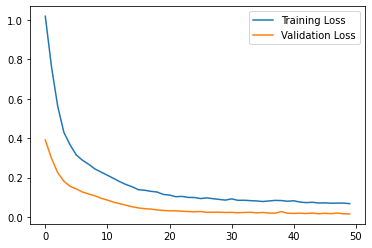

In [6]:
"""
    Entrenar el modelo modo autoencoder + earlyStopping.
"""

history = model.fit(
    x_train, # Data train
    x_train, # Labels objetivo (autoencoder)
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

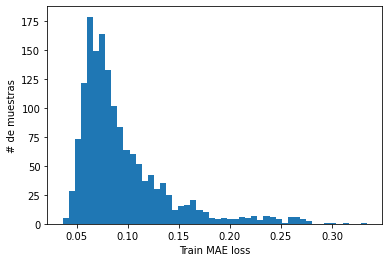

Umbral que se usará en test: 0.3341118810974011


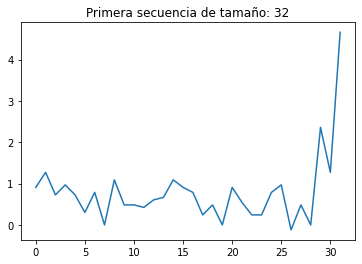

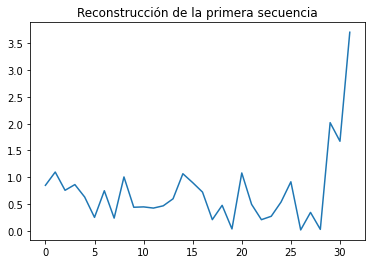

In [7]:
"""
    Se predice con la misma señal con la que se ha entrenado
    el autoencoder para conocer como de bien se reconstruye.
    Genera un error MAE/L1 por cada muestra y el mayor se 
    establece como el umbral de decisión de anomalía en test.
"""

# ¿Qué pérdida L1/MAE tiene su misma reconstrucción?
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("# de muestras")
plt.show()

# El máximo de las pérdidas es el umbral para el test
threshold = np.max(train_mae_loss)
print("Umbral que se usará en test:", threshold)

# Comprueba como se ha reconstruido la primera secuencia (sliding window)
plt.plot(x_train[0])
plt.title("Primera secuencia de tamaño: "+str(TIME_STEPS))
plt.show()
plt.plot(x_train_pred[0])
plt.title("Reconstrucción de la primera secuencia")
plt.show()

## Predecir con el test

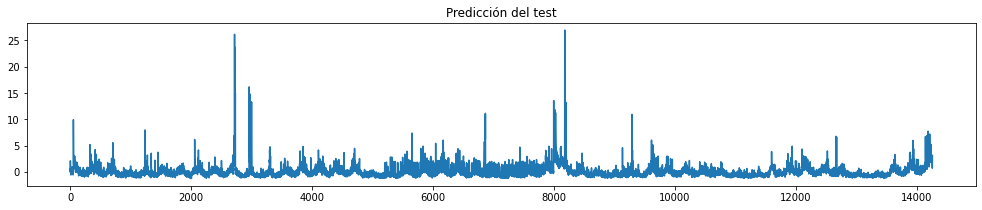

Test input shape:  (14225, 32, 1)


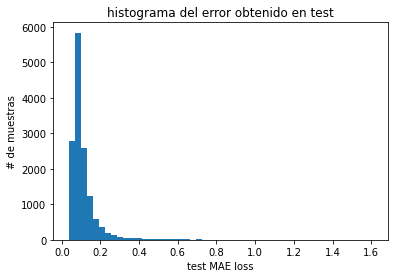

Number of anomaly samples:  403


In [8]:
"""
    1. Preparar el test del mismo modo que el train.
    2. Predecir el test y obtener su error MAE/L1.
    3. Filtrar el test los índices de las muestras 
    que superan el umbran obtenido por el train. 
"""

def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values

test_value = get_value_from_df(df_test)
test_value = normalize_test(test_value, training_mean, training_std)
plt.figure(figsize=(17,3))
plt.title('Predicción del test')
plt.plot(test_value.tolist())
plt.show()

# Crear las secuencias sliding window
x_test = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Obten el MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

# La predicción es una "columna"
test_mae_loss = test_mae_loss.reshape((-1)) 

# plot
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("# de muestras")
plt.title("histograma del error obtenido en test")
plt.show()

# ¿Cuantas muestras predichas tienen mas MAE que el umbral?
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
# print("Indices of anomaly samples: ", np.where(anomalies))


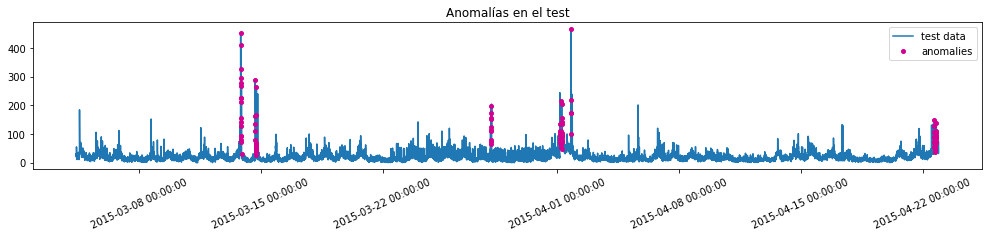

In [9]:
"""
    ¿Cómo saber que muestra es anómala?
    Si el resultado de la predicción última es:
    
    0, 1, 2, NO
    1, 2, 3, NO
    2, 3, 4, NO
    3, 4, 5, SÍ
    4, 5, 6, SÍ
    5, 6, 7, SÍ
    6, 7, 8, NO
    7, 8, 9, NO
    
    Es porque la muestra 5 es la anómala.
"""


# El punto i es anómalo si las ventanas anterior y siguiente [(i - timesteps + 1) to (i)] son anómalas
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if all([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)

# Plot       
df_subset = df_test.iloc[anomalous_data_indices, :]
plt.figure(figsize=(17,3))
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(xfmt)

dates = df_test["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_test["value"].to_list()
plt.plot(dates, values, label="test data")

dates = df_subset["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_subset["value"].to_list()
plt.plot(dates, values, 'go', color='#d40091', label="anomalies", markersize=4);

plt.legend()
plt.title("Anomalías en el test")
plt.show()